# Motivation
   The stock prediction has been a popular topic for many years but most people approach this problem by analyzing the stock performance in the past to obtain insights about market returns in the future. This approach has been proven to have many shortcomings since company’s performance is not linear and their stock data alone won’t be comprehensive enough to predict their stock movements in the future.
   The objective of our research is taken into account emotional states of a company combine with many quarterly fundamental data of companies to obtain a more comprehensive stock prediction model.
# Approach
   In order to investigate the impacts of emotional states on our stock model, we would first need to generate a sentiment scores of an observed company have news published on newspaper as well as stock prices announced on a given day. 
## Generating sentiment scores on financial news
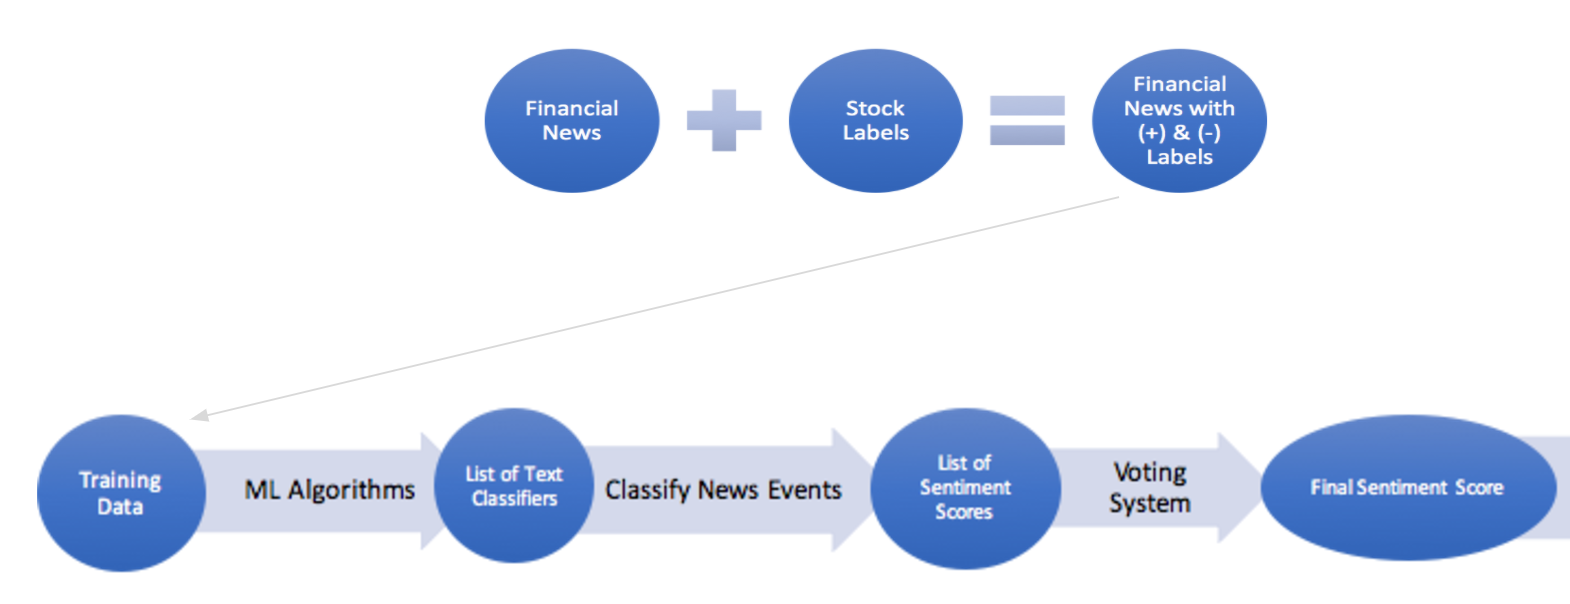

## Stock Classification 
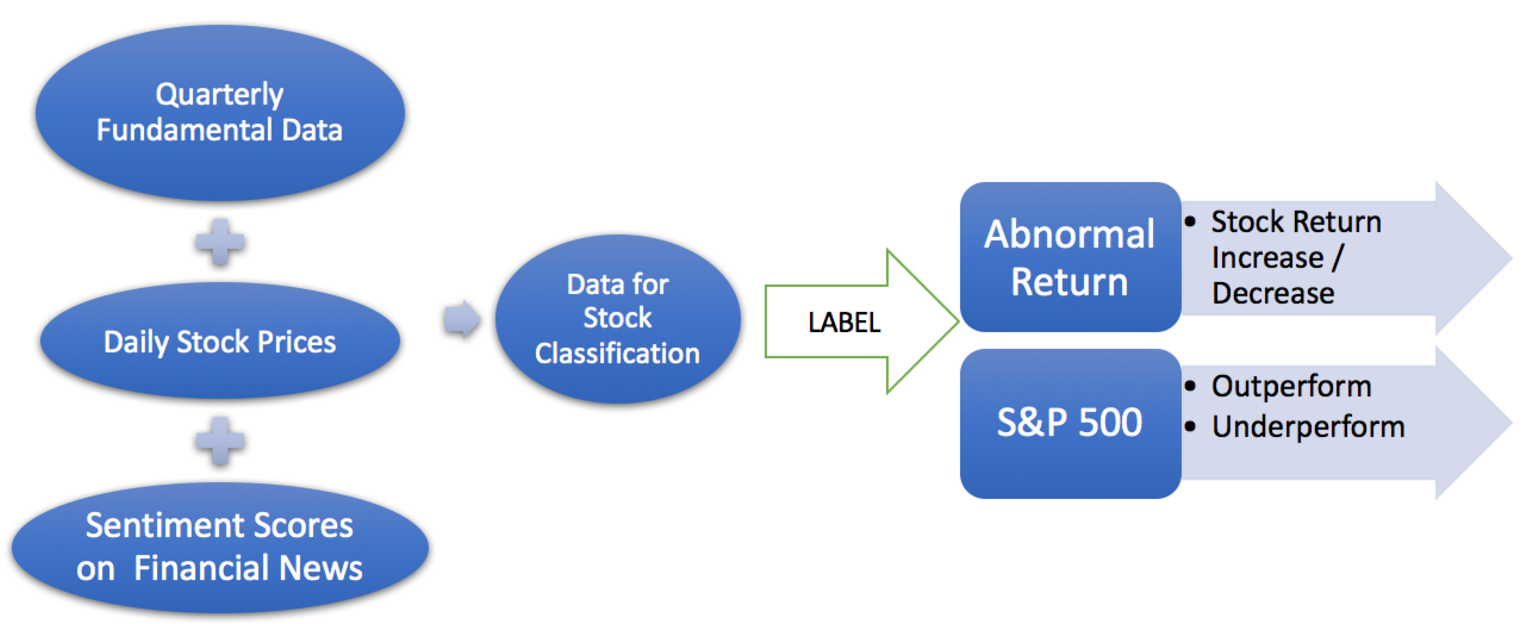

## Data Description
Our final dataset is the combination of historical stock data that reflects the pattern of stock movements, fundamental parameters that indicate the long-term financial health of a company, and the sentiment scores that symbolize the public opinions towards the given company.
### Financial quantitative data
There are 2 sources of financial data that we use in the analysis
-Daily historical stock price that we get from [Yahoo Finance](https://finance.yahoo.com/quote/AAPL/history?p=AAPL)
-The fundamental information of a company’s stocks, which has 198 features including figures such as  debt, equity, book values, etc. We get this data from [GuruFocus](https://www.gurufocus.com/term/Shares+Outstanding/AAPL/Shares-Outstanding-Diluted-Average/Apple-Inc)
### Financial news
We obtained financial news data by scraping articles related to 21 popular companies that have regularly appeared on the news from 01/01/2011 to the present. Although this was supposed to give us approximately 45,000 instances of various news events, there are many days where the observed companies don’t have any news, so after dropping all of the days with no news, we were left with a sample size of approximately 25,000 instances.

# Experiments
## 1. Building text classifiers for sentiment analysis

In [2]:
# import all the neccessary packages
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import numpy as np
import random
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier
import pickle 
import pdb
from nltk.stem import WordNetLemmatizer
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.stem import PorterStemmer
import math
from nltk.metrics.scores import accuracy, precision, recall
import collections
import os, sys
import time

-Because we have to process news articles for 21 different companies, it's better to write functions to read files of each company.
#### Step 1: Read data files

In [4]:
# Read news files of a company
def create_news_df(news_file):
    news_df = pd.read_csv(news_file, encoding = "ISO-8859-1")
    news_df['Date'] = pd.to_datetime(news_df['Date'], errors= 'coerce')
    news_df['Text'] = news_df['Body'].astype(str).str.cat(news_df['Title'].astype(str))
    del news_df['Body']
    del news_df['Title']
    news_df.fillna('', inplace=True)
    return news_df

In [ ]:
# Read Yahoo stock of a company
def create_stock_df(stock_file):
    #  append Target into News dataframe
    stock_df = pd.read_csv(stock_file, encoding = "ISO-8859-1")
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    return stock_df

### Step 2: Create labels for text classfication
To perform any classification task, we need to have labels for our data. Because we wanted to investigate how the news related to the stock movements, we decided that we should use some indicators of stock as the labels for the sentiment analysis model. One common binary stock indicator is comparing the stock returns with the return of S&P 500 index. This is a considerable assumption since the classification is assigned by aggregating the trades of everyone who reacts to the news, as well as the trades of other agents whose decisions are independent of what is in the news. So, to remedy this, we also did our experiments with another label involving the abnormal returns of a company.  
   Abnormal returns is the stock return of a company that is independent from the market movements. It’s the quantity that captures only the risk that is unique to the company’s stock.  
   We make an assumption that the return on a firm is directly connected to the news. This is a relatively big assumption because in financial news, the text is written by a reporter who has no control over how the market will react. The classification is assigned by aggregating the trades of everyone who reacts to the news, as well as the trades of other agents whose decisions are independent of what is in the news. However, this assumption is reasonable for our model in which we try to investigate the relationship between the financial news and stock performance.

In [6]:
# Combine news data and stock data of a company to prepare for label creation process
def combine_final_df(news_df, stock_df):
    df= stock_df.set_index('Date').join(news_df.set_index('Date'))
    df.fillna(0, inplace = True)
    df['Target'] = np.nan
    print(df.head())
    requirement = 0.00000
    for i in range(len(df)):
        if df['Abnormal Return'].iloc[i] > requirement:
            df['Target'].iloc[i] = 1.0
        elif df['Abnormal Return'].iloc[i] <  -requirement:
            df['Target'].iloc[i] = -1.0
        else:
            df['Target'].iloc[i] = 0.0
    return df

In [7]:
# We conduct experiments with data of 21 companies, so we have to combine processed data of these companies together to create 1 complete training dataset
def combine_multiple_company(company_list):  
    """
    Concatenate multiple dataframe of companies together to create big lexicon
    """
    company_dfs = []

    for company in company_list:
        print(company)
        news_file_name = 'News/'+ company + '_News.csv'
        news = create_news_df(news_file_name)
        stock_file_name = 'Abnormal_Returns/' + company + '_AbnormalReturn.csv'
        stock = create_stock_df(stock_file_name)

        final = combine_final_df(news, stock)
        company_dfs.append(final)
    total = pd.concat(company_dfs, ignore_index = True)
    return total